In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
insp = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
for col in insp.get_columns('measurement'):
    print(col['name'], col['type'])
print('~*~*~')
for col in insp.get_columns('station'):
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
~*~*~
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from dateutil.relativedelta import *

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
# session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = session.query(func.max(Measurement.date)).all()[0][0]

In [101]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date_one_year_prev_most_recent = (dt.datetime(2017, 8, 23) - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
previous_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date.between(date_one_year_prev_most_recent, most_recent_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
previous_year_prcp_df = pd.DataFrame(previous_year_prcp).sort_values('date').set_index('date').dropna()

# Sort the dataframe by date

previous_year_prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [103]:
previous_year_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


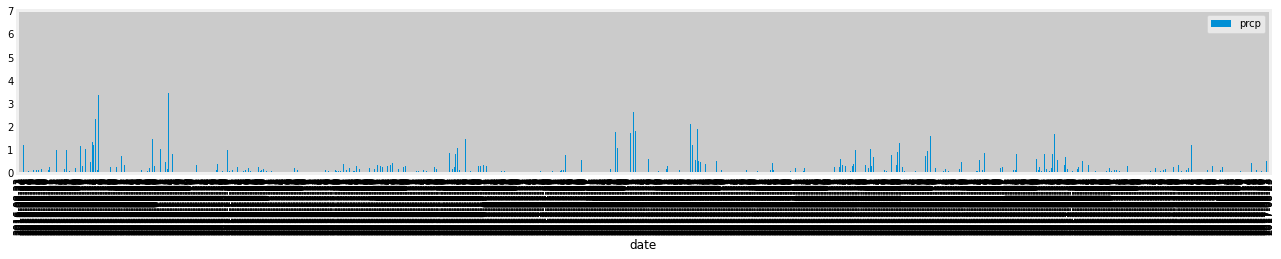

In [105]:
# Use Pandas Plotting with Matplotlib to plot the data
previous_year_prcp_df.plot.bar(y='prcp', figsize=(20,3))
ax = plt.gca()
for label in ax.get_xaxis().get_ticklabels()[::170]:
    label.set_visible(False);

In [13]:
# [(dt.datetime(2016, 8, 23) + relativedelta(months=+1)).strftime('%Y-%m-%d') for _ in range(0,13)]
def makeXLabels():
    xlabels = [dt.datetime(2016, 8 , 23)]
    i = 0
    while len(xlabels) != 13:
        xlabels.append(xlabels[i] + relativedelta(months=+1))
        i += 1
    return [date.strftime('%Y-%m-%d') for date in xlabels]

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(func.count(Station.station)).all()[0][0]

In [59]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()

In [72]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = list(map(max, zip(*station_count))) 

In [91]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_past_year_table = session.query(
    Measurement.station, Measurement.tobs).join(
    Station, Station.station == Measurement.station, isouter=True).filter(
    Measurement.station == most_active_station[0]).filter(
    Measurement.date.between(date_one_year_prev_most_recent, most_recent_date)).all()

In [94]:
most_active_station_past_year_df = pd.DataFrame(most_active_station_past_year_table)

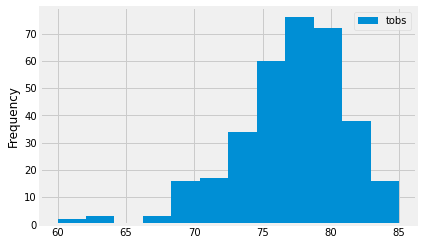

In [95]:
most_active_station_past_year_df.plot.hist(bins=12);

# Close session

In [ ]:
# Close Session
session.close()